In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, Dense, LSTM, Dropout
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv('cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [3]:
df.shape

(47692, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
df.isnull().values.any()

False

In [6]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [7]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

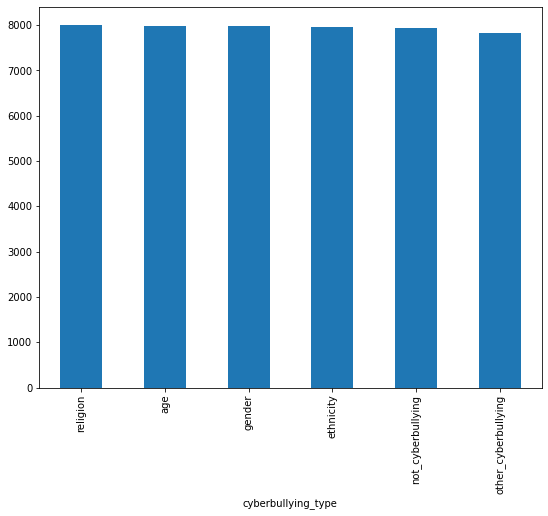

In [8]:
df['cyberbullying_type'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.show()

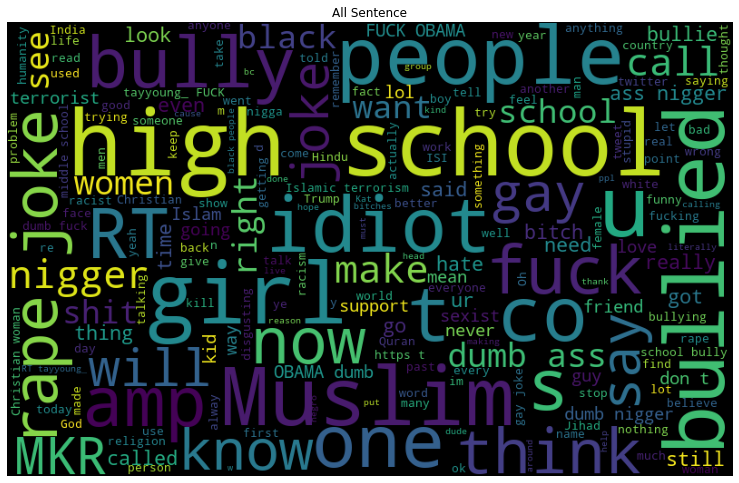

In [9]:
plt.figure(figsize = (13, 13))
all_sen = ' '.join([sentence for sentence in df['tweet_text']])
wordcloud_all = WordCloud(height = 500, width = 800, random_state = 101, max_font_size = 100).generate(all_sen)
plt.imshow(wordcloud_all)
plt.axis('off')
plt.title('All Sentence')
plt.show()

In [10]:
def word_cloud(b):
    plt.figure(figsize = (13, 13))
    sen = ' '.join([sentence for sentence in df['tweet_text'][df['cyberbullying_type']==b]])
    wordcloud_sen = WordCloud(height = 500, width = 800, random_state = 101, max_font_size = 100).generate(sen)
    plt.imshow(wordcloud_sen)
    plt.title(b)
    plt.axis('off')
    plt.show()

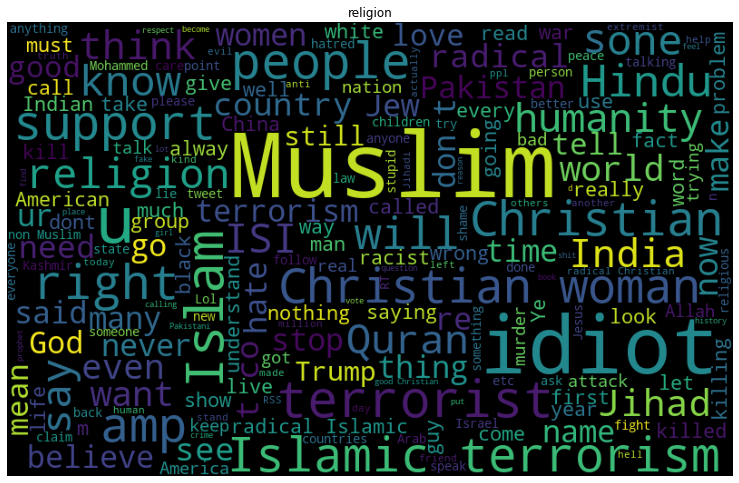

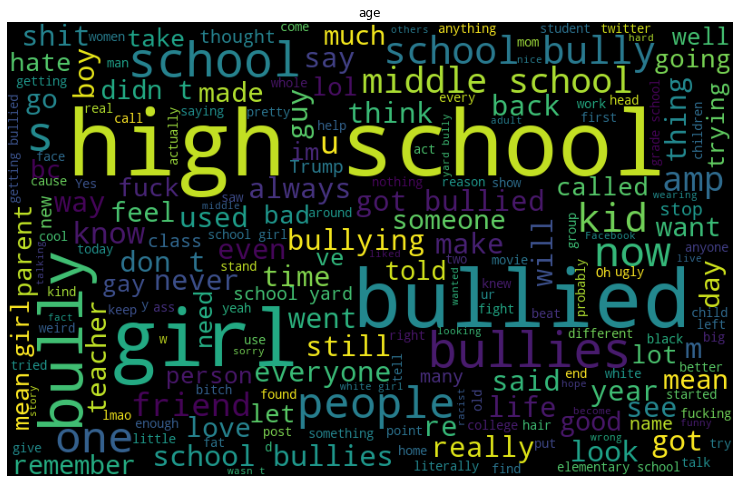

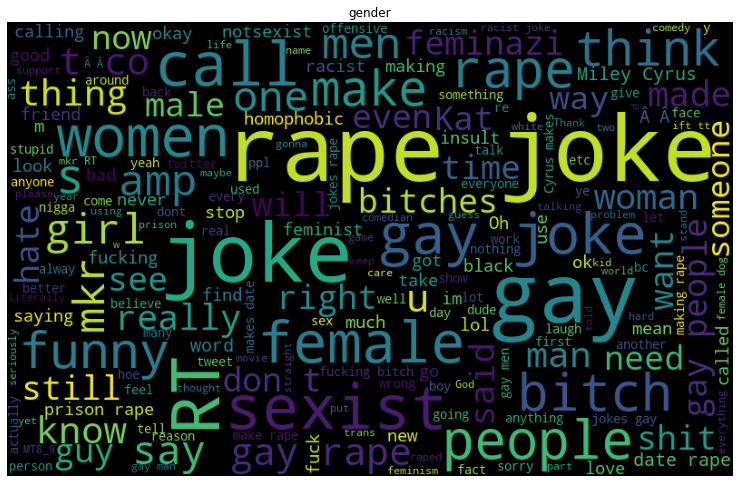

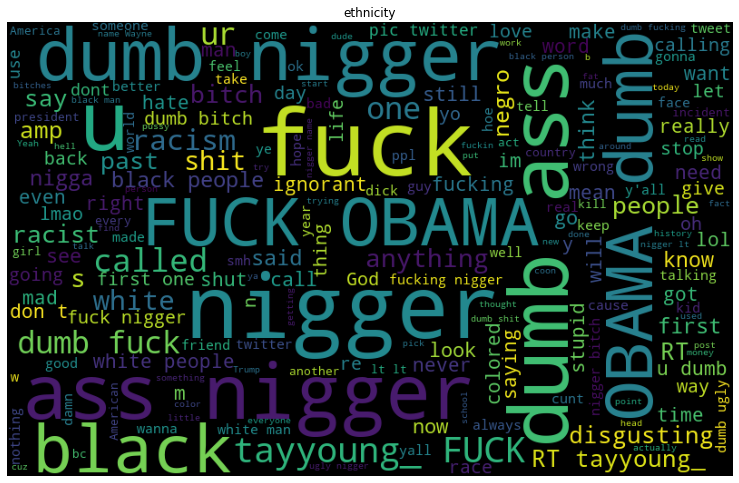

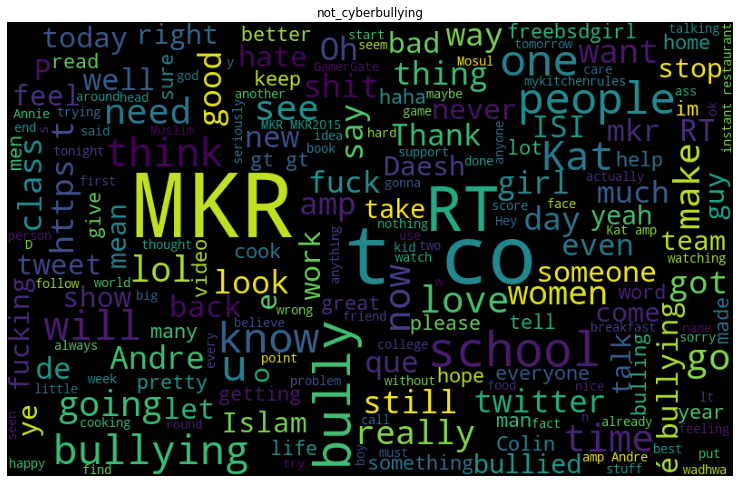

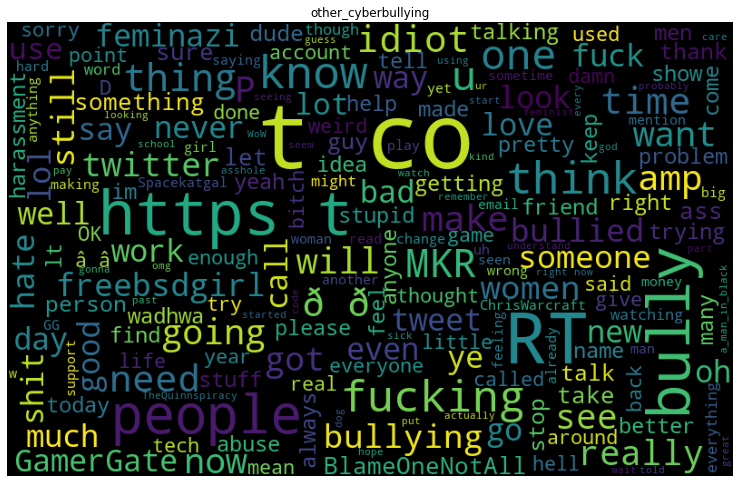

In [11]:
for i in df['cyberbullying_type'].value_counts().index.tolist():
    word_cloud(i)

In [12]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [13]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in sw])

In [14]:
df['pre_text'] = df['tweet_text'].apply(text_preprocessing)

In [15]:
df.head()

,tweet_text,cyberbullying_type,pre_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,xochitlsuckkks classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,jason gio meh thanks head concerned another an...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,rudhoeenglish isi account pretending kurdish a...


In [16]:
df.drop(columns=['tweet_text'], axis = 1, inplace = True)

In [17]:
df.head()

,cyberbullying_type,pre_text
0,not_cyberbullying,word katandandre food crapilicious mkr
1,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,not_cyberbullying,xochitlsuckkks classy whore red velvet cupcake
3,not_cyberbullying,jason gio meh thanks head concerned another an...
4,not_cyberbullying,rudhoeenglish isi account pretending kurdish a...


In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['pre_text'])
se = tokenizer.texts_to_sequences(df['pre_text'])
se[:10]

[[89, 2281, 587, 21598, 25],
 [21599, 28, 25, 14790, 8704, 159, 14791, 5552, 7784, 21600, 209],
 [21601, 2044, 1162, 717, 9984, 4923],
 [2190, 5553, 3445, 330, 213, 1525, 164, 655, 204, 84],
 [11822, 104, 379, 1778, 3011, 379, 3, 54, 308],
 [5554, 6438, 7025, 123, 1526, 111, 64, 88, 8705, 311, 439, 2227, 111, 2435],
 [5934, 9985, 327, 8706, 21602, 7, 4043, 14792, 3572, 21603],
 [1044, 194, 2531, 145, 1211, 832, 25],
 [6439, 236, 687, 3012],
 [2532, 22, 970, 1, 641, 62]]

In [19]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

54311

In [20]:
maxlen = max([len(i) for i in se])
maxlen

489

In [21]:
pad_seq = pad_sequences(se, maxlen = maxlen, padding = 'post')
pad_seq

array([[   89,  2281,   587, ...,     0,     0,     0],
       [21599,    28,    25, ...,     0,     0,     0],
       [21601,  2044,  1162, ...,     0,     0,     0],
       ...,
       [  740,   111,     8, ...,     0,     0,     0],
       [  895,     2,    16, ...,     0,     0,     0],
       [  440,   608,  1287, ...,     0,     0,     0]])

In [22]:
le = LabelEncoder()
y = le.fit_transform(df['cyberbullying_type'])
y

array([3, 3, 3, ..., 1, 1, 1])

In [23]:
X, y = shuffle(pad_seq, y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify = y, shuffle = True)

In [25]:
X_train.shape

(38153, 489)

In [26]:
X_test.shape

(9539, 489)

In [27]:
app_sen = df['pre_text'].apply(gensim.utils.simple_preprocess)
app_sen

0             [word, katandandre, food, crapilicious, mkr]
1        [aussietv, white, mkr, theblock, imacelebritya...
2        [xochitlsuckkks, classy, whore, red, velvet, c...
3        [jason, gio, meh, thanks, head, concerned, ano...
4        [rudhoeenglish, isi, account, pretending, kurd...
                               ...                        
47687    [black, ppl, expected, anything, depended, any...
47688    [turner, withhold, disappointment, turner, cal...
47689    [swear, god, dumb, nigger, bitch, got, bleach,...
47690    [yea, fuck, rt, therealexel, youre, nigger, fu...
47691    [bro, gotta, chill, rt, chillshrammy, dog, fuc...
Name: pre_text, Length: 47692, dtype: object

In [28]:
wv_model = gensim.models.Word2Vec(
    window = 10, 
    min_count = 2, 
    workers = 4
)

In [29]:
wv_model.build_vocab(app_sen, progress_per = 1000)

In [30]:
wv_model.train(app_sen, total_examples = df.shape[0], epochs = 50)

(27649281, 32466050)

In [31]:
wv_model.wv.most_similar('good')

[('terrible', 0.40694141387939453),
 ('bad', 0.39263734221458435),
 ('important', 0.34271374344825745),
 ('different', 0.3418006896972656),
 ('great', 0.33727070689201355),
 ('respect', 0.33112549781799316),
 ('close', 0.32047978043556213),
 ('plenty', 0.3199555277824402),
 ('anyhow', 0.3158843517303467),
 ('challenged', 0.3115609884262085)]

In [32]:
wv_model.wv.most_similar('school')

[('bully', 0.6125307083129883),
 ('girl', 0.5720177292823792),
 ('bullied', 0.5706755518913269),
 ('junior', 0.539323627948761),
 ('kid', 0.5026438236236572),
 ('class', 0.501617431640625),
 ('college', 0.4572206437587738),
 ('constantly', 0.4552154242992401),
 ('schooler', 0.4543860852718353),
 ('grew', 0.4527808427810669)]

In [33]:
wv_model.wv.similarity(w1 = 'school', w2 = 'class')

0.5016175

In [34]:
def get_vector(model):
    embedding_vec = np.zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        try:
            embedding_vec[index] = model.wv[word]
        except:
            pass
    return embedding_vec

In [35]:
embedding_vectors = get_vector(wv_model)

In [36]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.90379846,  0.85529828,  3.04390836, ..., -1.19954169,
         0.34090477, -1.57926106],
       [ 0.16533759, -1.01290977,  0.83970308, ..., -2.27360535,
        -4.67102051,  3.00200438],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [37]:
embedding_vectors[300]

array([-3.67897964, -1.02892959,  0.82515955,  4.24366093, -0.59455127,
        1.24865508,  1.87126708, -2.82477117,  0.47388837,  2.18306351,
       -1.11410153,  0.81310499,  1.31420064,  1.03518331, -1.59982109,
        1.57150471, -3.15821528, -2.16369057, -1.00241017,  3.47878504,
       -1.58246171, -2.04794788,  1.47000635, -2.99742913, -1.27837706,
        2.85877681,  1.41808176, -4.00794601, -3.42882299, -0.24646181,
        2.20364141, -2.38430095, -2.45246744,  1.9409368 , -0.95991874,
       -2.03245401,  2.57437778,  1.11343014, -3.4677465 , -3.2016747 ,
        1.08214605, -0.15589517, -1.32486486, -1.25923133,  2.84759855,
       -4.09730721,  1.87285936,  2.61161399, -4.54017973, -1.25838041,
       -0.65903825, -2.9446516 ,  1.04694617, -4.51413631,  1.61876953,
        1.20344746, -1.48647773,  6.12523079,  4.14866924,  0.04465848,
       -1.39613318, -3.11851048,  3.27801633,  0.28979534, -1.76162601,
        1.92932498,  2.128968  ,  0.21120788,  1.11052275,  3.22

In [38]:
model = Sequential()

In [39]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Conv1D(32, 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(15)))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))

In [40]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['Accuracy']
)

In [41]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [42]:
history = model.fit(X_train, y_train, validation_split = 0.1, callbacks=[early_stopping], epochs = 100)

Epoch 1/100
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 186s 168ms/step - Accuracy: 0.6698 - loss: 0.9124 - val_Accuracy: 0.8163 - val_loss: 0.4385
Epoch 2/100
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 185s 172ms/step - Accuracy: 0.8226 - loss: 0.4475 - val_Accuracy: 0.8305 - val_loss: 0.4016
Epoch 3/100
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 193s 180ms/step - Accuracy: 0.8387 - loss: 0.4021 - val_Accuracy: 0.8383 - val_loss: 0.3952
Epoch 4/100
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 193s 180ms/step - Accuracy: 0.8622 - loss: 0.3525 - val_Accuracy: 0.8375 - val_loss: 0.3834
Epoch 5/100
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 189s 176ms/step - Accuracy: 0.8811 - loss: 0.3148 - val_Accuracy: 0.8417 - val_loss: 0.3920
Epoch 6/100
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 189s 176ms/step - Accuracy: 0.8949 - loss: 0.2832 - val_Accuracy: 0.8381 - val_loss: 0.4183


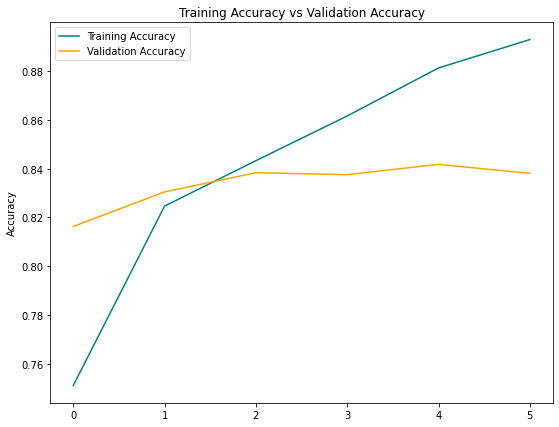

In [43]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['Accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_Accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

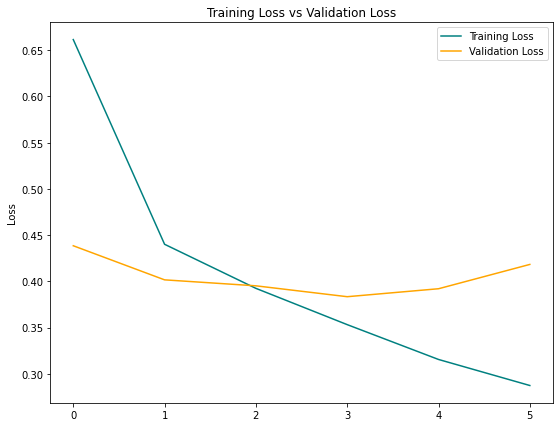

In [44]:
plt.figure(figsize = (9, 7))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
y_p = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_p]

299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1598
           1       0.99      0.98      0.98      1592
           2       0.90      0.84      0.87      1595
           3       0.68      0.52      0.59      1589
           4       0.62      0.80      0.70      1565
           5       0.95      0.96      0.95      1600

    accuracy                           0.85      9539
   macro avg       0.85      0.85      0.84      9539
weighted avg       0.85      0.85      0.84      9539



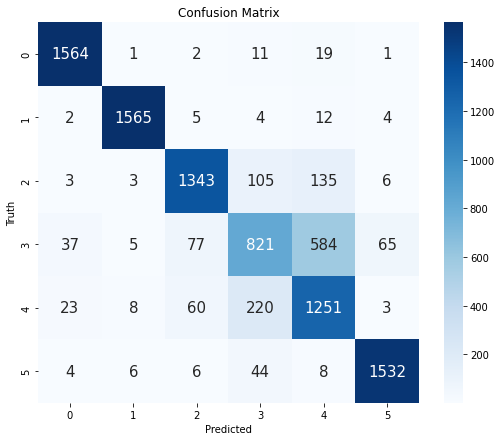

In [47]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = True, annot_kws = {'size' : 15}, fmt = 'd', 
           cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [48]:
embedding_matrix = dict()
glove_file = open('glove.6B.100d.txt', encoding = 'utf-8')
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [49]:
embedding_vectors2 = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vect = embedding_matrix.get(word)
    if vect is not None:
        embedding_vectors2[index] = vect

In [50]:
model2 = Sequential()

In [51]:
model2.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors2), trainable = False))
model2.add(Conv1D(32, 3, padding = 'same', activation = 'relu'))
model2.add(MaxPooling1D(pool_size = 2))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(15)))
model2.add(Dropout(0.2))
model2.add(Dense(6, activation = 'softmax'))

In [52]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [53]:
history2 = model2.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping], epochs = 100)

Epoch 1/100
954/954 ━━━━━━━━━━━━━━━━━━━━ 177s 179ms/step - accuracy: 0.6502 - loss: 0.9419 - val_accuracy: 0.8158 - val_loss: 0.4528
Epoch 2/100
954/954 ━━━━━━━━━━━━━━━━━━━━ 174s 183ms/step - accuracy: 0.8248 - loss: 0.4369 - val_accuracy: 0.8285 - val_loss: 0.4074


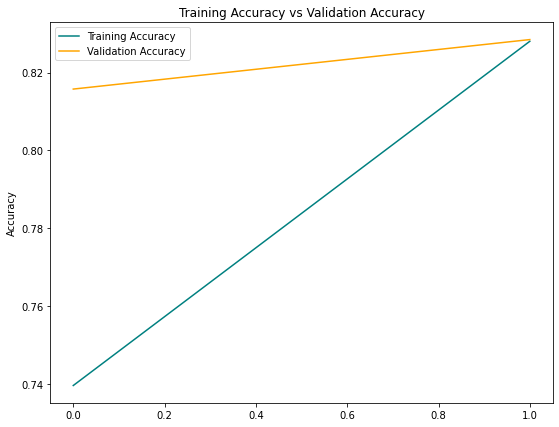

In [54]:
plt.figure(figsize = (9, 7))
plt.plot(history2.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

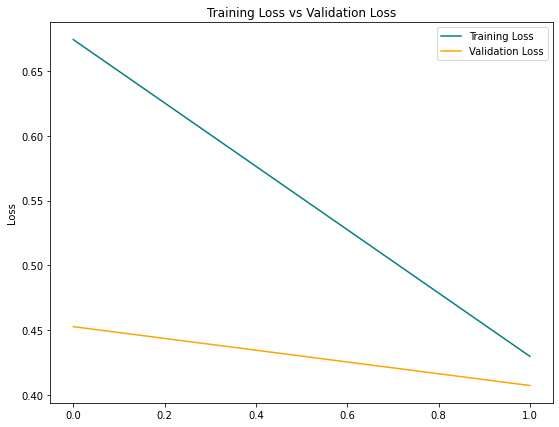

In [55]:
plt.figure(figsize = (9, 7))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
y_p2 = model2.predict(X_test)
y_pred2 = [np.argmax(i) for i in y_p2]

299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


In [58]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1598
           1       0.98      0.98      0.98      1592
           2       0.92      0.81      0.86      1595
           3       0.59      0.61      0.60      1589
           4       0.62      0.67      0.65      1565
           5       0.95      0.96      0.96      1600

    accuracy                           0.83      9539
   macro avg       0.84      0.83      0.84      9539
weighted avg       0.84      0.83      0.84      9539



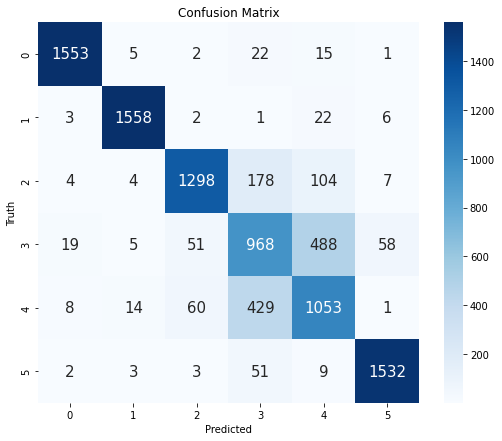

In [60]:
plt.figure(figsize = (9, 7))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot = True, square = True, cbar = True, annot_kws = {'size' : 15}, fmt = 'd', 
           cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()